In [4]:
# Run first

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.express as px
import pandas as pd
import cufflinks as cf
import json as js
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import itertools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import os
import action_selection as asl
from itertools import product, repeat
import jsonpickle as pickle
import jsonpickle.ext.numpy as jsonpickle_numpy
import json

import perception as prc
import agent as agt
from environment import PlanetWorld
from agent import BayesianPlanner
from world import World
from planet_sequences import generate_trials_df
from multiprocessing import Pool
import time


# functions
def load_file_names(arrays):
    lst = []
    for i in product(*arrays):
        lst.append(list(i))
    
    names = []
    print('files to load: ' + str(len(lst)))
    for li, l in enumerate(lst):
        prefix = ''
        if l[0] == True:
            prefix += 'switch1_'
        else:
            prefix +='switch0_'

        if l[1] == True:
            prefix += 'degr1_'
        else:
            prefix += 'degr0_'

        fname = prefix + 'p' + str(l[4])  +'_learn_rew' + str(int(l[2] == True))+ '_q' + str(l[3]) + '_h' + str(l[5]) + '_' +\
        str(l[8]) + '_' + str(l[6]) + str(l[7]) + '.json'
        names.append(fname)

    return names

def load_df(names,data_folder='data'):
    # if not just_simulated:
    path = os.path.join(os.getcwd(),data_folder)
    #     names = os.listdir(path)

    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)

    dfs = [None]*len(names)

    for f,fname in enumerate(names):
        jsonpickle_numpy.register_handlers()

        with open(fname, 'r') as infile:
            data = json.load(infile)
        
        worlds = pickle.decode(data)
        meta = worlds[-1]
        agents = [w.agent for w in worlds[:-1]]
        perception = [w.agent.perception for w in worlds[:-1]]
        nt = worlds[0].T
        npl = perception[0].npl
        nr = worlds[0].agent.nr
        nc = perception[0].nc
        nw = len(worlds[:-1])
        ntrials = meta['trials']
        learn_rew = np.repeat(meta['learn_rew'], ntrials*nw*nt)
        switch_cues = np.repeat(meta['switch_cues'], ntrials*nw*nt)
        contingency_degradation = np.repeat(meta['contingency_degradation'], ntrials*nw*nt)
        ntrials_df = np.repeat(meta['trials_per_block'], ntrials*nw*nt)
        ndb = np.repeat(meta['degradation_blocks'], ntrials*nw*nt)
        ntb = np.repeat(meta['training_blocks'], ntrials*nw*nt)
        post_dir_rewards = [a.posterior_dirichlet_rew for a in agents]
        post_dir_rewards = [post[:,1:,:,:] for post in post_dir_rewards]
        entropy_rewards = np.zeros([nw*ntrials*nt,nc])

        for ip, post in enumerate(post_dir_rewards):
            post = post.sum(axis=3)
            norm = post.sum(axis=2)
            reward_distributions = np.zeros(post.shape)

            for r in range(nr):
                reward_distributions[:,:,r,:] = np.divide(post[:,:,r,:],norm)
            entropy = np.zeros([ntrials, nt, nc])

            for trl in range(ntrials):
                for t in range(nt-1):
                    prob = reward_distributions[trl,t,:,:].T
                    entropy[trl,t+1,:] = -(np.log(prob)*prob).sum(axis=1)

            entropy[:,0,:] = None
            entropy_rewards[ip*(ntrials*nt):(ip+1)*(ntrials*nt),:] = np.reshape(entropy, [ntrials*nt,nc])

        entropy_context = np.zeros(ntrials*nt*nw)
        post_context = [a.posterior_context for a in agents]

        for ip, post in enumerate(post_context):
            entropy = np.zeros([ntrials, nt])

            for trl in range(ntrials):
                entropy[trl,:] = -(np.log(post[trl,:])*post[trl,:]).sum(axis=1) 
            entropy_context[ip*(ntrials*nt):(ip+1)*(ntrials*nt)] = np.reshape(entropy, [ntrials*nt])

        posterior_context = [agent.posterior_context for agent in agents]
        observations = [w.observations for w in worlds[:-1]]
        context_cues = worlds[0].environment.context_cues
        policies = worlds[0].agent.policies
        actions = [w.actions[:,:3] for w in worlds[:-1]] 
        true_optimal = np.tile(np.repeat(meta['optimal_sequence'],nt), nw)
        cue = np.tile(np.repeat(context_cues, nt), nw)
        ex_p = np.zeros(ntrials)
        executed_policy = np.zeros(nw*ntrials,dtype='int32')
        optimality = np.zeros(nw*ntrials)
        chose_optimal = np.zeros(nw*ntrials)

        for w in range(nw):
            for pi, p in enumerate(policies):
                inds = np.where( (actions[w][:,0] == p[0]) & (actions[w][:,1] == p[1]) & (actions[w][:,2] == p[2]) )[0]
                ex_p[inds] = pi
            executed_policy[w*ntrials:(w+1)*ntrials] = ex_p
            ch_op = executed_policy[w*ntrials:(w+1)*ntrials] == meta['optimal_sequence']
            chose_optimal[w*ntrials:(w+1)*ntrials] = ch_op
            optimality[w*ntrials:(w+1)*ntrials] = np.cumsum(ch_op)/(np.arange(ntrials)+1)

        executed_policy = np.repeat(executed_policy, nt)
        chose_optimal = np.repeat(chose_optimal, nt)
        optimality = np.repeat(optimality, nt)
        no = perception[0].generative_model_context.shape[0]
        optimal_contexts = [np.argmax(perception[0].generative_model_contexts[i,:] for i in range(no))]
        true_context = 0
        q = np.repeat(meta['context_trans_prob'], ntrials*nw*nt)
        p = np.repeat(meta['cue_ambiguity'], ntrials*nw*nt)
        h = np.repeat(meta['h'], ntrials*nw*nt)
        switch_cues = np.repeat(meta['switch_cues'], ntrials*nw*nt)
        learn_rew = np.repeat(meta['learn_rew'], ntrials*nw*nt)
        degradation = np.repeat('contingency_degradation', ntrials*nw*nt)
        trial_type = np.tile(np.repeat(meta['trial_type'], nt), nw)
        trial = np.tile(np.repeat(np.arange(ntrials),nt), nw)
        run = np.repeat(np.arange(nw),nt*ntrials)
        run.astype('str')
        inferred_context_t0 = np.zeros(ntrials*nw*nt,dtype='int32')
        inferred_context_t3  = np.zeros(ntrials*nw*nt,'int32')
        agnt = np.repeat(np.arange(nw)+f*nw,nt*ntrials)
        no, nc = perception[0].generative_model_context.shape 
        modes_gmc =  perception[0].generative_model_context.argsort(axis=1)
        contexts = [modes_gmc[i,:][-2:] for i in range(no)] # arranged in ascending order!
        if_inferred_context_switch = np.zeros(ntrials, dtype="int32")

        for i in range(no):    
            c = np.array([contexts[i][-1]]*(meta['trials_per_block']*meta['training_blocks'])\
                + [contexts[i][-2]]*(meta['trials_per_block']*meta['degradation_blocks'])\
                + [contexts[i][-1]]*meta['trials_per_block'])
            if_inferred_context_switch[np.where(context_cues == i)] = c[np.where(context_cues == i)]
        inferred_switch = np.zeros(ntrials*nw,dtype='int32')
        context_optimality = np.zeros(ntrials*nw)

        for w in range(nw):
            inferred_context_t0[w*ntrials:(w+1)*ntrials] = np.argmax(posterior_context[w][:,0,:],axis=1)
            inferred_context_t3[w*ntrials:(w+1)*ntrials] = np.argmax(posterior_context[w][:,-1,:],axis=1)
            inferred_switch[w*ntrials:(w+1)*ntrials] = if_inferred_context_switch == \
                                                    inferred_context_t3[w*ntrials:(w+1)*ntrials]
            context_optimality[w*ntrials:(w+1)*ntrials] = np.cumsum(inferred_switch[w*ntrials:(w+1)*ntrials])\
                                                                /(np.arange(ntrials)+1)
    
        inferred_switch = np.repeat(inferred_switch, nt)
        context_optimality = np.repeat(context_optimality, nt)
        t = np.tile(np.arange(4), nw*ntrials)
        
        d = {'trial_type':trial_type, 'run':run, 'trial':trial, 't':t, 'true_optimal':true_optimal,\
                            'cue':cue, 'q':q, 'p':p, 'h':h, 'inferred_context_t0':inferred_context_t0,\
                            'inferred_context_t3':inferred_context_t3, 'executed_policy':executed_policy,\
                            'chose_optimal': chose_optimal, 'entropy_rew_c1': entropy_rewards[:,0], 'entropy_rew_c2': entropy_rewards[:,1], \
                            'entropy_rew_c3': entropy_rewards[:,2] , 'entropy_rew_c4': entropy_rewards[:,3],\
                            'policy_optimality':optimality,'agent':agnt, 'inferred_switch': inferred_switch,\
                            'context_optimality':context_optimality, 'learn_rew': learn_rew, 'entropy_context':entropy_context, \
                            'switch_cues':switch_cues, 'contingency_degradation': contingency_degradation,\
                            'degradation_blocks': ndb, 'training_blocks':ntb, 'trials_per_block': ntrials_df} 
        dfs[f] = pd.DataFrame(d)
    data = pd.concat(dfs)
    data.astype({'h': 'category'})

    return data


Load specific simulation files and create dataframe

In [5]:
# Create list of file names for some parameters
nc = 4

h =  [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,100]
cue_ambiguity = [0.5, 0.6, 0.7,0.8]                       
context_trans_prob = [1/nc -0.1, 1/nc, 1/nc+0.1]                
degradation = [True]
cue_switch = [False]
reward_naive = [False, True]
training_blocks = [4]
degradation_blocks=[2,4,6]
trials_per_block=[60]
data_folder = 'data'
arrays = [cue_switch, degradation, reward_naive, context_trans_prob, cue_ambiguity,h,\
        training_blocks, degradation_blocks, trials_per_block]

names = load_file_names(arrays)
df = load_df(names, data_folder='temp')


files to load: 1224


Context Exploration plots

Looks like an increse in certainty ob observation meaning makes the traces for different habitual tendnencies collapse into each other for ambiguos context transition beliefs (q=1/nc). This tendency is visible for q = 1/nc - 0.1 but appears at a higher p. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


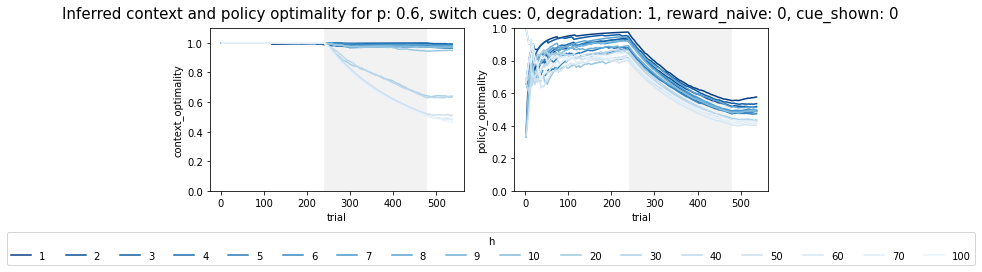

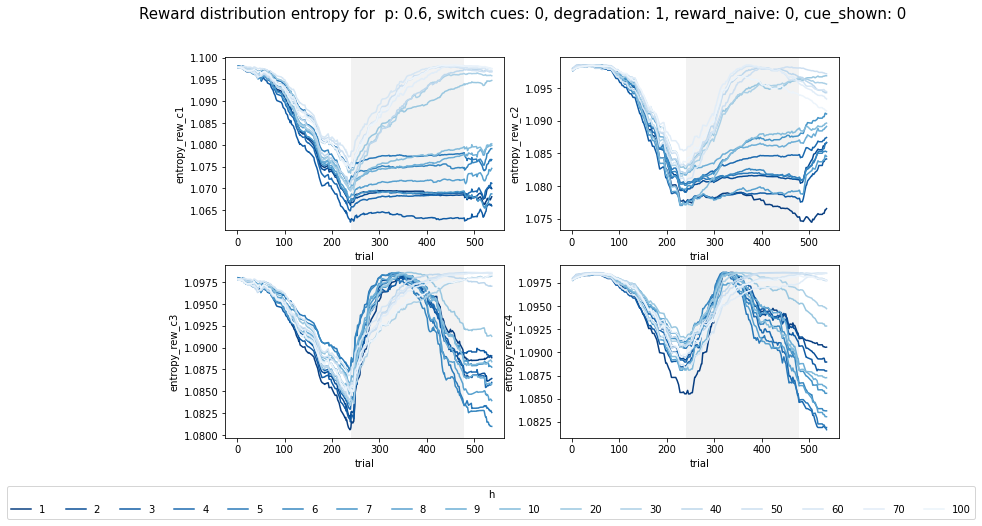

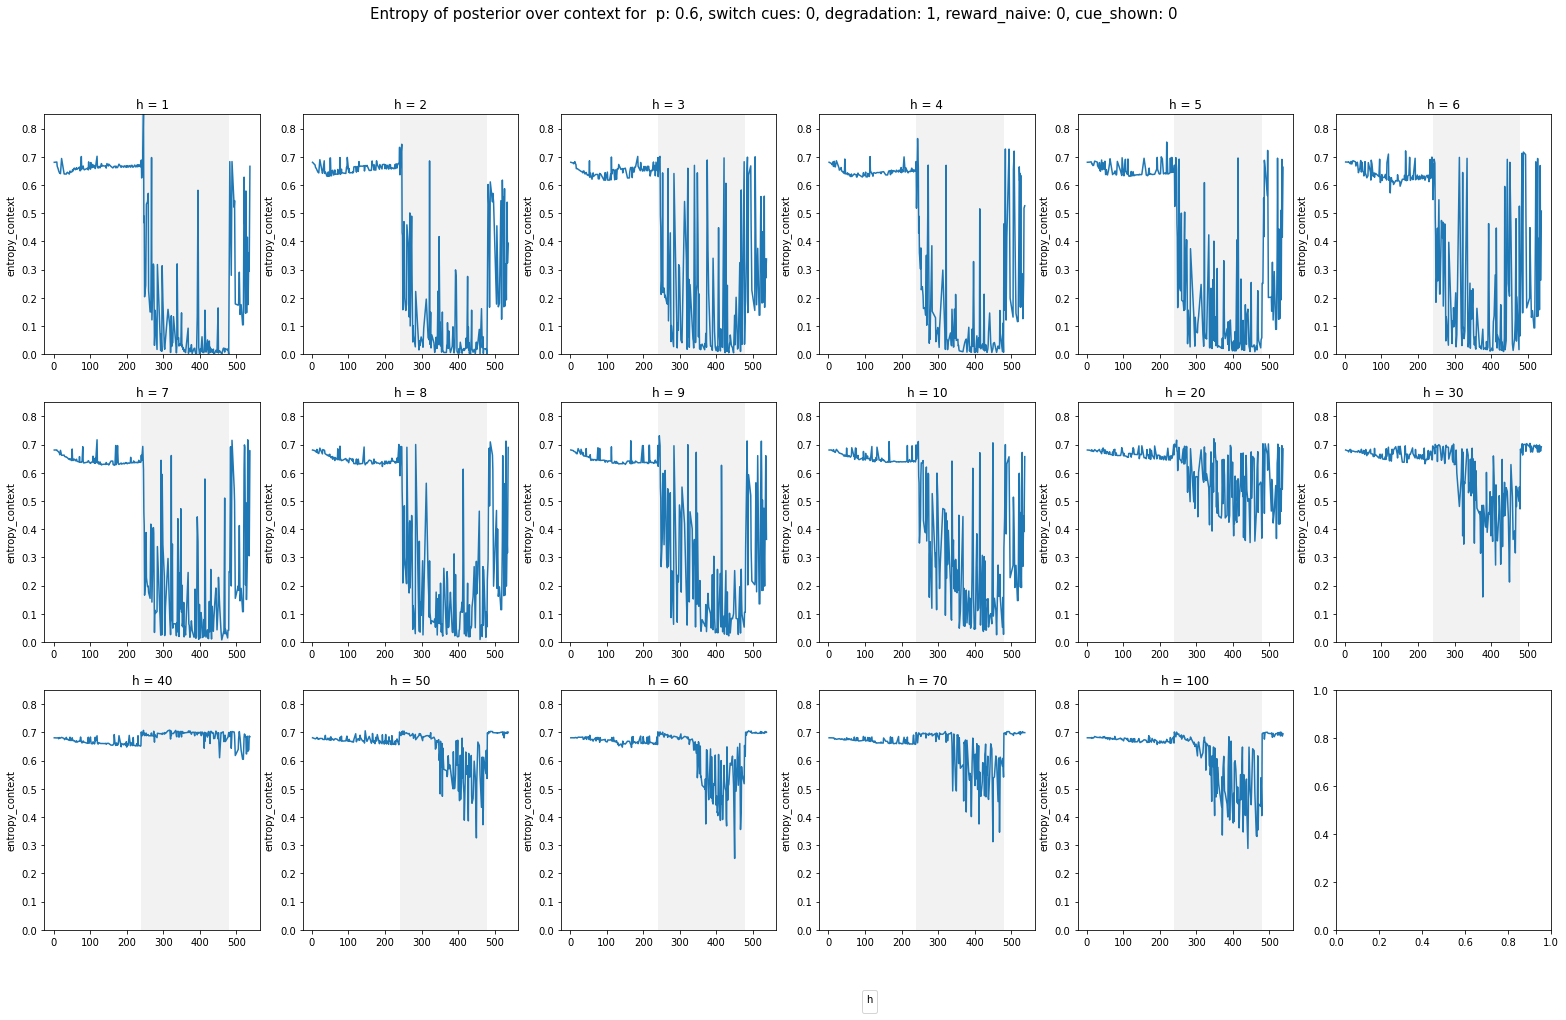

In [7]:
# context plot

# base query parameters
switch = False
contingency_degr = True
learn_r = False
q = 0.25
h = 100
t = 3
trials_per_block = 60
training_blocks = 4
degradation_blocks = 4
cue = 0
strs = np.array(['switch_cues==', '& contingency_degradation==', '& learn_rew==', '& q==', '& h<=',\
                 '& training_blocks==', '& degradation_blocks==', '& trials_per_block=='],dtype='str')
vals = np.array([switch, contingency_degr, learn_r, q, h,\
                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = df.query(base_query)
queries = ['p==0.6','p==0.7']


def context_plots(query='p == 0.6'):

    # context and policy optimality
    fig = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plot_df = base_df.query(query + '& t ==' + str(t) + ' & cue == ' + str(cue))
    plot_df['h'] = plot_df['h'].astype('category')
    ax = sns.lineplot(data=plot_df, x='trial', y='context_optimality', hue='h',\
                      palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size), legend=False)
    ax.set(ylim = (0,1.1))
    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)

    # reward distribution entropy for different contexts
    plt.subplot(1,2,2)
    ax = sns.lineplot(data=plot_df, x='trial', y='policy_optimality', hue='h',\
            palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size))
    ax.legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-2, -0.25), loc='upper left', borderaxespad=0,title='h')
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)

    ax.set(ylim = (0,1))
    # title = base_query + ' & ' + query
    # title = title.replace(' & ', ', ')
    # title = title.replace('==', ':')
    title = 'Inferred context and policy optimality for p: ' + query[-3:] + ', switch cues: ' + str(int(switch)) + ', degradation: ' + str(int(contingency_degr)) + ', reward_naive: ' + str(int(learn_r)) + \
            ', cue_shown: ' + str(cue)
    fig.suptitle(title, fontsize=15)

    # entropy of reward distribution for each context 
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))
    axs_flat = axs.flatten()
    legs = [False, False, False, True]
    ys = ['entropy_rew_c1', 'entropy_rew_c2','entropy_rew_c3','entropy_rew_c4',]
    for c in range(nc):
        sns.lineplot(ax=axs_flat[c], data=plot_df, x='trial',y=ys[c],hue='h',\
            palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size), legend=legs[c])
        cols = [[1,1,1], [0,0,0],[1,1,1]]
        for i, row in ranges.iterrows():
            axs_flat[c].axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)
        axs_flat[-1].legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-2, -0.25), loc='upper left', borderaxespad=0.5,title='h')
    
    title = 'Reward distribution entropy for  p: ' + query[-3:] + ', switch cues: ' + str(int(switch)) + ', degradation: ' + str(int(contingency_degr)) + ', reward_naive: ' + str(int(learn_r)) + \
            ', cue_shown: ' + str(cue)
    fig.suptitle(title, fontsize=15)

    # entropy of posterior over contexts
    fig,axes = plt.subplots(nrows=3, ncols=6,figsize = (27,15))
    hs = np.unique(plot_df['h'])
    for ai, ax in enumerate(axes.flatten()[:-1]):
        plot_df = base_df.query(query + '& t ==' + str(t) + ' & cue == ' + str(cue) + ' & h==' + str(hs[ai]))
        sns.lineplot(ax=ax, data=plot_df, x='trial', y='entropy_context', legend=False)
        cols = [[1,1,1], [0,0,0],[1,1,1]] 
        for i, row in ranges.iterrows():
            ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)
        ax.set_title('h = ' + str(hs[ai]))
        ax.set(xlabel=None)
        ax.set(ylim=[0,0.85])
    ax.legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-1, -0.25), loc='upper left', borderaxespad=0,title='h')
    title = 'Entropy of posterior over context for  p: ' + query[-3:] + ', switch cues: ' + str(int(switch)) + ', degradation: ' + str(int(contingency_degr)) + ', reward_naive: ' + str(int(learn_r)) + \
            ', cue_shown: ' + str(cue)
    fig.suptitle(title, fontsize=15)

context_plots(queries[0])   

For p=0.6, agents with h>= 30 fail at inferring a context change which indicates contingency degradation (contingency degradation trials are shown in gray). This can be seen in figure 1, left panel. More habitual agents can infer a context change. 

This can also be seen in the entropy over the reward distributions and the posterior over contexts I think? For h<30 agents we have a decrease in entropy for all reward distributions, independent of context, because the posterior over contexts is still relativelly undefined. However, once the contingency degradation trials start the habitual agents infer a context change and correspondingly the reward distribution for context 3 and 4 starts to grow again because of the increased uncertainty in reward contingencies, whilst the entropy stays relatively unchanged due to the inferred context change.

For less habitual agents the reward distribution changes in a similar manner for all contexts due to the comparatively flat posterior over contexts, compared to the habitual agents. Since there are no peaks in the posterior reward contingencies are updates similarly across all contexts. 

In this graph the case of contingency degradation without cue switching was explored. Degradation trials were as many as normal trials. In graph A inferred context and policy choice is plotted. Conclusions: less habitual agents struggle to infer a context change? Need to explore if this is till the case when there is more/less context uncertainty. 

In the lower graph I have plotted the entropy over reward distribution given context with the planet variable integrated out (p(r|p,c)). As expected

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


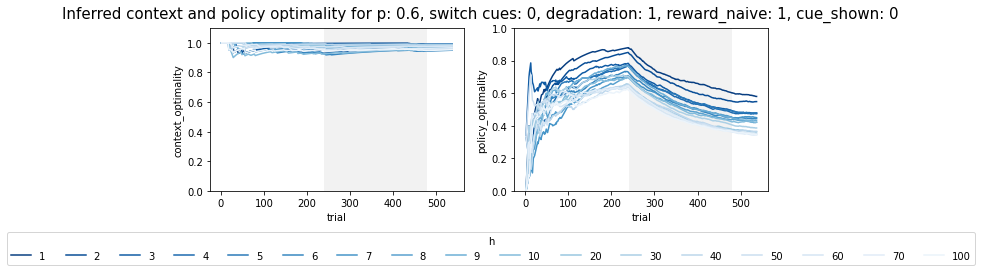

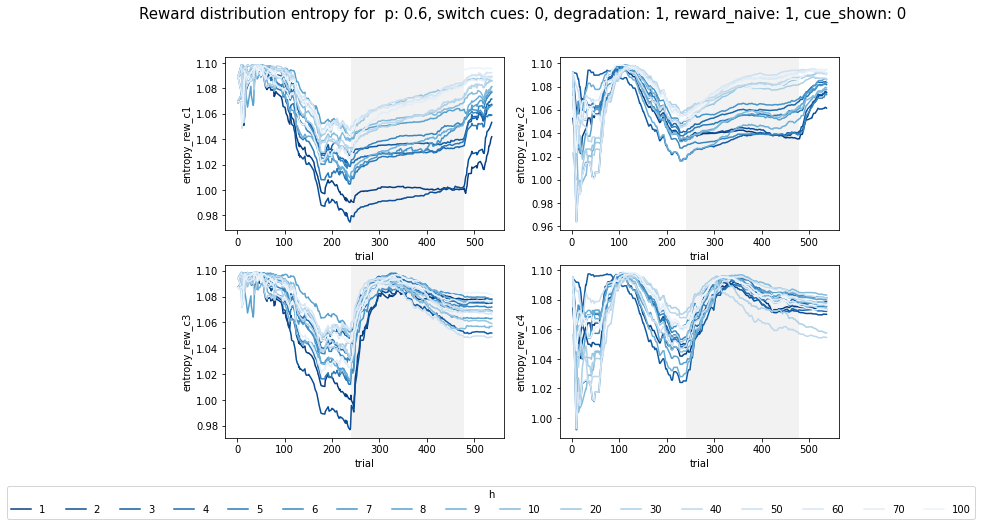

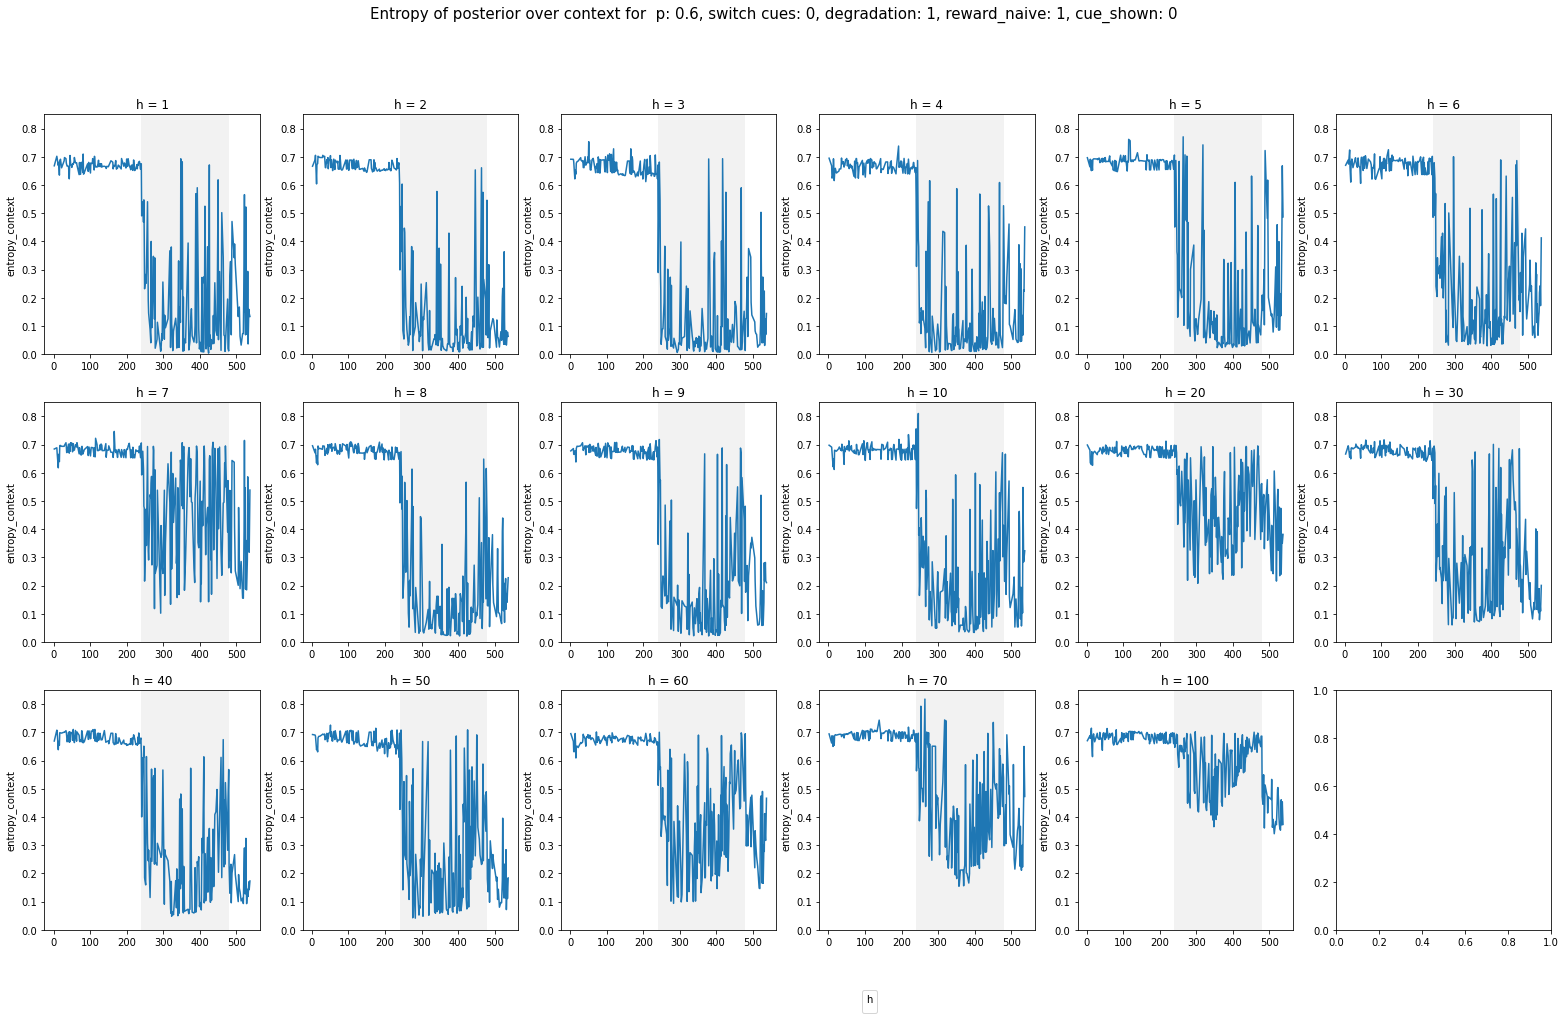

In [45]:
switch = False
contingency_degr = True
learn_r = True
q = 0.25
h = 100
t = 3
trials_per_block = 60
training_blocks = 4
degradation_blocks = 4
cue = 0
strs = np.array(['switch_cues==', '& contingency_degradation==', '& learn_rew==', '& q==', '& h<=',\
                 '& training_blocks==', '& degradation_blocks==', '& trials_per_block=='],dtype='str')
vals = np.array([switch, contingency_degr, learn_r, q, h,\
                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = df.query(base_query)

context_plots('p == 0.6')

Highly habitual agents do manage to infer a context change when they are reward naive, meaning that the initial reward counts are 1 for all rewards and all contexts. The agent above started with the correct probabilities multiplied by a 100 as initial counts which is probably too high. I should try with a midway regime of starting with the initial probabilities multipied by 2 or 5 or something so the agent is still flexible but has an idea of rewards.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


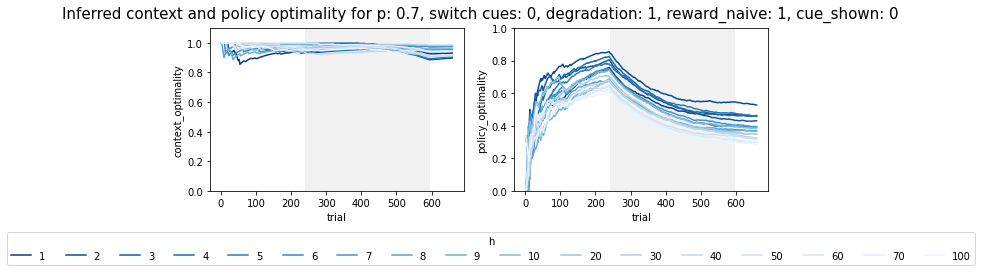

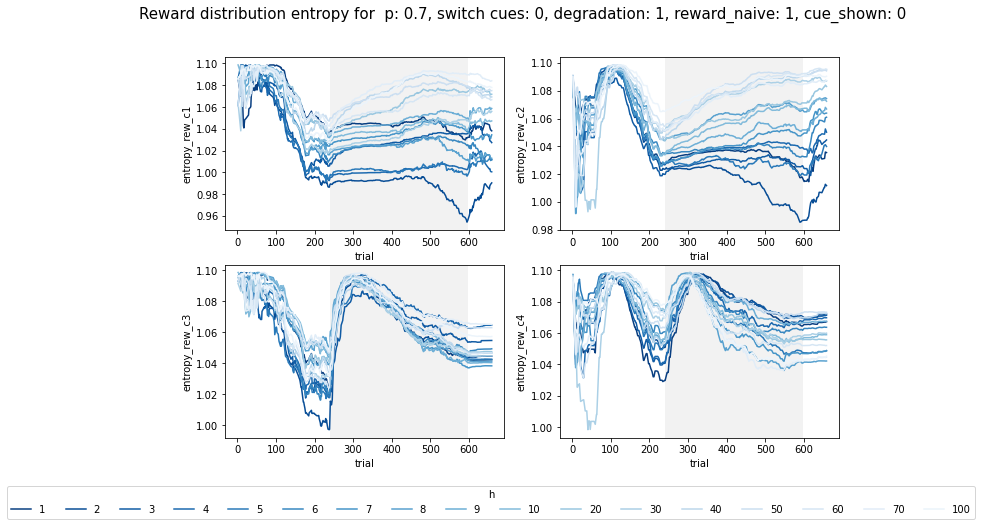

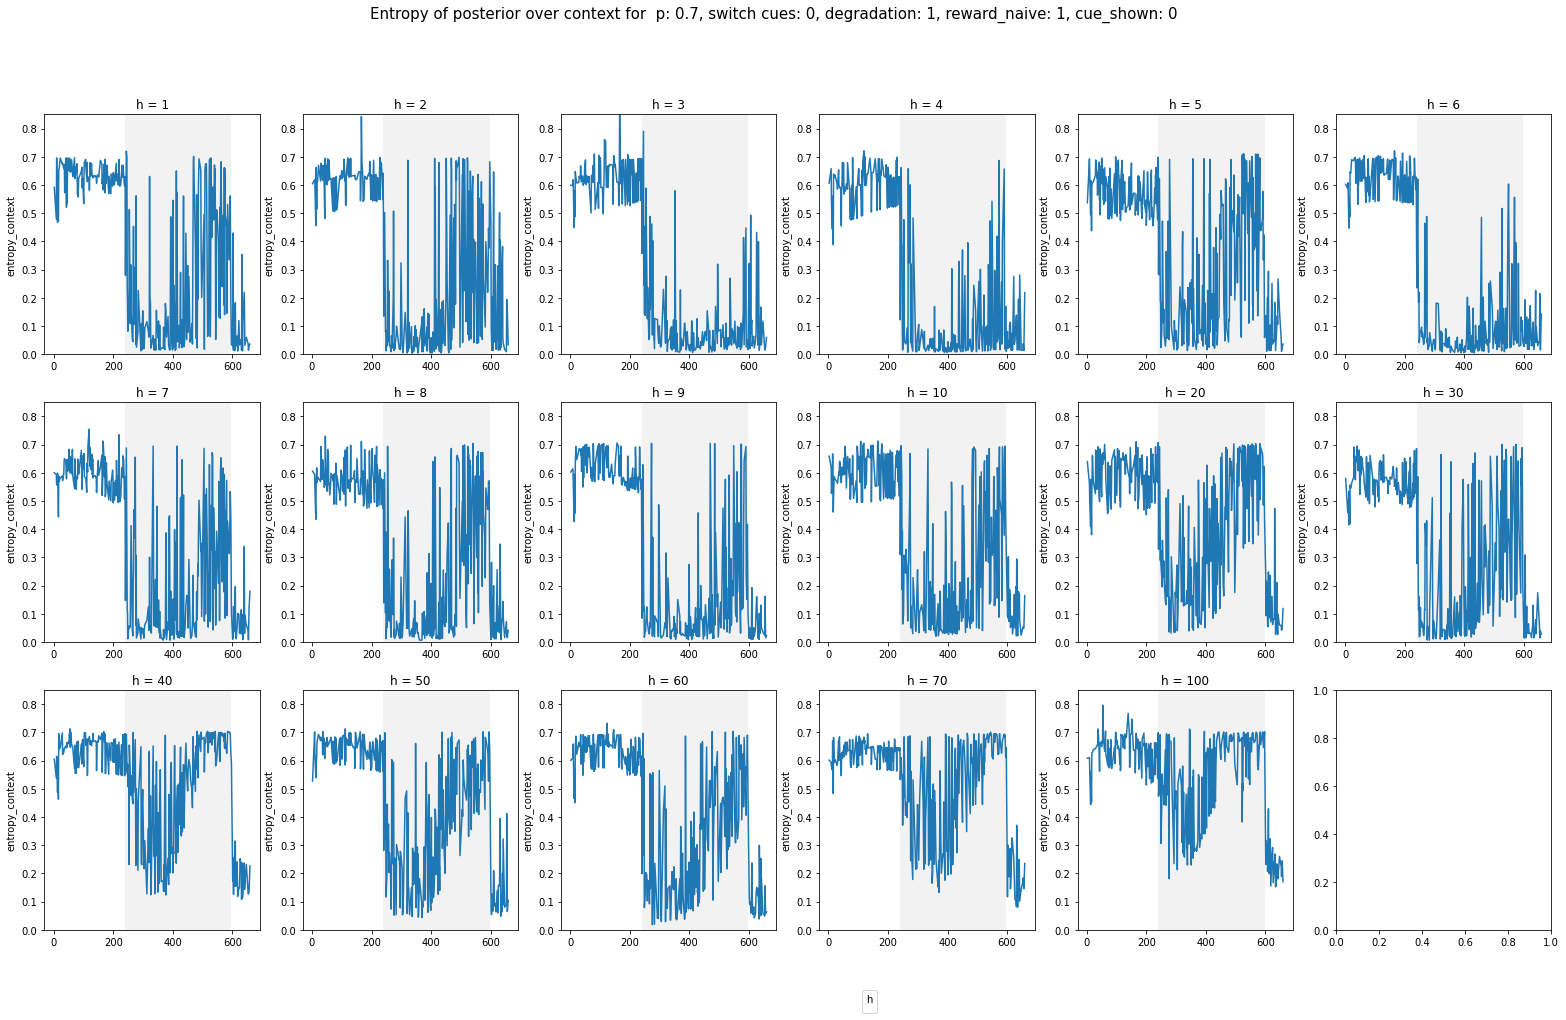

In [44]:
switch = False
contingency_degr = True
learn_r = True
q = 0.25
h = 100
t = 3
trials_per_block = 60
training_blocks = 4
degradation_blocks = 6
cue = 0
strs = np.array(['switch_cues==', '& contingency_degradation==', '& learn_rew==', '& q==', '& h<=',\
                 '& training_blocks==', '& degradation_blocks==', '& trials_per_block=='],dtype='str')
vals = np.array([switch, contingency_degr, learn_r, q, h,\
                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = df.query(base_query)

context_plots('p == 0.7')

571200


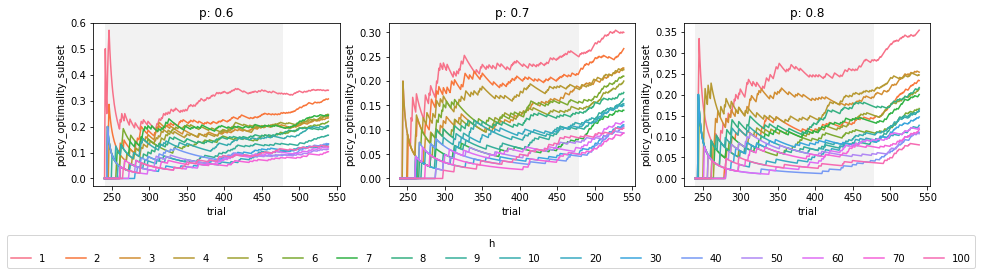

In [46]:
ps = [0.6,0.7, 0.8]

plot_df = base_df.query('trial_type > 0 & trial_type <= 2 &t==0')
plot_df = plot_df.astype({'h': 'category'})
print(plot_df.size)
plot_df['policy_optimality_subset'] = plot_df.groupby(by=['agent', 'run','h'])['chose_optimal'].apply(np.cumsum) / \
                                           (plot_df['trial'] - np.min(plot_df['trial'])+1)   

fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (15,3))

lgnd = [False, False, True]
for p, ax in enumerate(axes.flatten()):
    sns.lineplot(ax=ax, data=plot_df.query('p=='+str(ps[p])), x = 'trial',y='policy_optimality_subset', hue='h',legend=lgnd[p])
    ax.set_title('p: ' + str(ps[p]))
    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)

ax.legend(bbox_to_anchor=(-2.75,-0.3), loc='upper left', borderaxespad=0,title='h',ncol=np.unique(plot_df['h'].size))



It looks like most agents  start to relearn rewards contingencies. All agents irrespective of habituality and cue ambiguity infer the right context after extinction when rewards are still being given.

456960


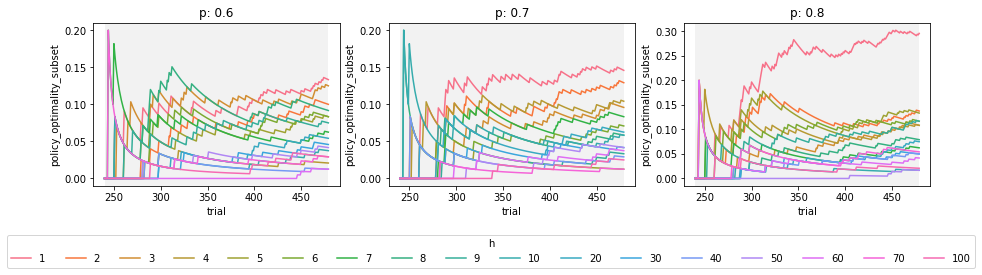

In [43]:
ps = [0.6,0.7, 0.8]

plot_df = base_df.query('trial_type == 1 & t==0')
plot_df = plot_df.astype({'h': 'category'})
print(plot_df.size)
plot_df['policy_optimality_subset'] = plot_df.groupby(by=['agent', 'run','h'])['chose_optimal'].apply(np.cumsum) / \
                                           (plot_df['trial'] - np.min(plot_df['trial'])+1)   

fig, axes = plt.subplots(ncols=3, nrows=1, figsize = (15,3))

lgnd = [False, False, True]
for p, ax in enumerate(axes.flatten()):
    sns.lineplot(ax=ax, data=plot_df.query('p=='+str(ps[p])), x = 'trial',y='policy_optimality_subset', hue='h',legend=lgnd[p])
    ax.set_title('p: ' + str(ps[p]))
    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)

ax.legend(bbox_to_anchor=(-2.75,-0.3), loc='upper left', borderaxespad=0,title='h',ncol=np.unique(plot_df['h'].size))



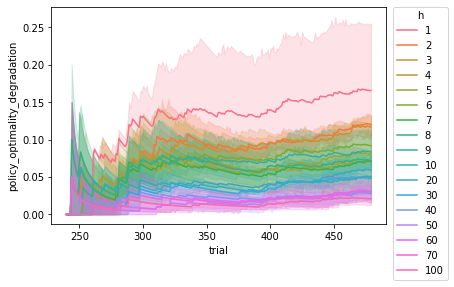

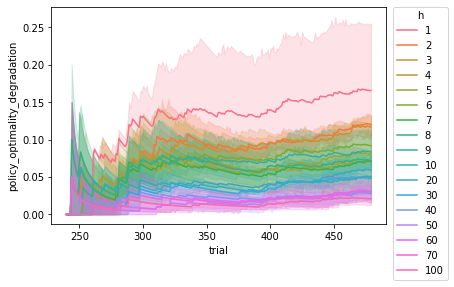

In [124]:
switch = False
contingency_degr = True
learn_r = False
q = 0.25
h = 100
t = 3
trials_per_block = 60
training_blocks = 4
degradation_blocks = 4
cue = 0
strs = np.array(['switch_cues==', '& contingency_degradation==', '& learn_rew==', '& q==', '& h<=',\
                 '& training_blocks==', '& degradation_blocks==', '& trials_per_block=='],dtype='str')
vals = np.array([switch, contingency_degr, learn_r, q, h,\
                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = df.query(base_query)


plot_df = base_df.query('trial_type == 1 & t==0')
plot_df = plot_df.astype({'h': 'category'})

plot_df['policy_optimality_degradation'] = plot_df.groupby(by=['agent', 'run','h'])['chose_optimal'].apply(np.cumsum) / \
                                           (plot_df['trial'] - np.min(plot_df['trial'])+1)   

plt.figure()
ax = sns.lineplot(data=plot_df, x = 'trial',y='policy_optimality_degradation', hue='h')
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0,title='h')
ax.figure


Animation scripts

In [4]:
#df for animation 

just_simulated = False
data_folder = 'temp'

if not just_simulated:
    path = os.path.join(os.getcwd(),data_folder)
    names = os.listdir(path)

    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)


overall_df = [None]*len(names)
for f,fname in enumerate(names):
    jsonpickle_numpy.register_handlers()

    with open(fname, 'r') as infile:
        data = json.load(infile)

    worlds = pickle.decode(data)
    meta = worlds[-1]
    nw = len(worlds[:-1])
    agents = [w.agent for w in worlds[:-1]]
    perception = [w.agent.perception for w in worlds[:-1]]
    posterior_context = [agent.posterior_context for agent in agents]
    ntrials, t, nc = posterior_context[0].shape

    taus = np.arange(ntrials)
    ts = np.arange(t)
    cs = np.arange(nc)
    mi = pd.MultiIndex.from_product([taus, ts, cs], names=['trial', 't', 'context'])
    dfs = [None]*nw
    factor = ntrials*nc*t

    for w in range(nw):
        df = pd.Series(index=mi, data=posterior_context[w].flatten())
        df = df.reset_index().rename(columns = {0:'probability'})
        df['learn_rew'] = np.repeat(meta['learn_rew'], factor)
        df['switch_cues'] = np.repeat(meta['switch_cues'], factor)
        df['contingency_degradation'] = np.repeat(meta['contingency_degradation'], factor)
        df['trials_per_block'] = np.repeat(meta['trials_per_block'], factor)
        df['degradation_blocks'] = np.repeat(meta['degradation_blocks'], factor)
        df['training_blocks'] = np.repeat(meta['training_blocks'], factor)
        df['context_cues'] = np.repeat(worlds[0].environment.context_cues, nc*t)
        df['true_optimal'] = np.repeat(meta['optimal_sequence'], nc*t)
        df['q'] = np.repeat(meta['context_trans_prob'], factor)
        df['p'] = np.repeat(meta['cue_ambiguity'], factor)
        df['h'] = np.repeat(meta['h'], factor)
        df['run'] = np.repeat(w,factor)
        df['trial_type'] = np.repeat(meta['trial_type'], nc*t)
        df['trial'] = np.repeat(np.arange(ntrials), nc*t)
        df['agent'] = np.repeat(w+f*nw,factor)
        dfs[w] = df
    
    overall_df[f] = pd.concat(dfs)

data_animation = pd.concat(overall_df)
data_animation.to_csv('data_animation.csv')


In [8]:
# create animation
from itertools import cycle
switch = False
contingency_degr = True
learn_r = False
q = 0.25
h = 9
trials_per_block = 60
training_blocks = 4
degradation_blocks = 4
strs = np.array(['switch_cues == ', '& contingency_degradation==', '& learn_rew==', '& q==', '& h>',\
                 '& training_blocks == ', '& degradation_blocks == ', '& trials_per_block =='],dtype='str')
vals = np.array([switch, contingency_degr, learn_r, q, h,\
                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = data_animation.query(base_query)
plot_df = base_df.query('p==0.6 & context_cues == 1 & t==3')

fig = px.line(plot_df, x='context', y='probability',animation_frame='trial',animation_group='h', color="h", range_y=[0,1])

trial_type = plot_df.groupby(by=['trial'])['trial_type'].mean().to_numpy().astype('int32')

for i, frame in enumerate(fig.frames):
    frame.layout.title = "Trial type: {}".format(trial_type[i])

for step in fig.layout.sliders[0].steps:
    step["args"][1]["frame"]["redraw"] = True

fig.show()

Simulate Data

In [17]:
# using a copy of run single sim because of different data pathway
from run_exampe_habit_v1 import run_agent

def run_single_sim(lst,
                    ns,
                    na,
                    npl,
                    nc,
                    nr,
                    T,
                    state_transition_matrix,
                    planet_reward_probs,
                    planet_reward_probs_switched,
                    repetitions):


    switch_cues, contingency_degradation, reward_naive, context_trans_prob, cue_ambiguity, h,\
    training_blocks, degradation_blocks, trials_per_block = lst
    
    config = 'config' + '_degradation_'+ str(int(contingency_degradation)) \
                      + '_switch_' + str(int(switch_cues))                \
                      + '_train' + str(training_blocks)                   \
                      + '_degr' + str(degradation_blocks)                 \
                      + '_n' + str(trials_per_block)+'.json'

    folder = os.getcwd()

    file = open(os.path.join(folder,config))

    task_params = js.load(file)                                                                                 

    colors = np.asarray(task_params['context'])          # 0/1 as indicator of color
    sequence = np.asarray(task_params['sequence'])       # what is the optimal sequence
    starts = np.asarray(task_params['starts'])           # starting position of agent
    planets = np.asarray(task_params['planets'])         # planet positions 
    trial_type = np.asarray(task_params['trial_type'])
    blocks = np.asarray(task_params['block'])


    nblocks = int(blocks.max()+1)         # number of blocks
    trials = blocks.size                  # number of trials
    block = task_params['trials_per_block']           # trials per block
 
    meta = {
        'trial_file' : config, 
        'trial_type' : trial_type,
        'switch_cues': switch_cues == True,
        'contingency_degradation' : contingency_degradation == True,
        'learn_rew' : reward_naive == True,
        'context_trans_prob': context_trans_prob,
        'cue_ambiguity' : cue_ambiguity,
        'h' : h,
        'optimal_sequence' : sequence,
        'blocks' : blocks,
        'trials' : trials,
        'nblocks' : nblocks,
        'degradation_blocks': task_params['degradation_blocks'],
        'training_blocks': task_params['training_blocks'],
        'interlace': task_params['interlace'],
        'contingency_degrdataion': task_params['contingency_degradation'],
        'switch_cues': task_params['switch_cues'],
        'trials_per_block': task_params['trials_per_block']
    }

    all_optimal_seqs = np.unique(sequence)                                                                            

    # reward probabilities schedule dependent on trial and planet constelation
    Rho = np.zeros([trials, nr, ns])

    for i, pl in enumerate(planets):
        if i >= block*meta['training_blocks'] and i < block*(meta['training_blocks'] + meta['degradation_blocks']) and contingency_degradation:
            # print(i)
            # print(pl)
            Rho[i,:,:] = planet_reward_probs_switched[tuple([pl])].T
        else:
            Rho[i,:,:] = planet_reward_probs[tuple([pl])].T

    u = 0.99
    utility = np.array([(1-u)/2,(1-u)/2,u])

    if reward_naive==True:
        reward_counts = np.ones([nr, npl, nc])
    else:
        reward_counts = np.tile(planet_reward_probs.T[:,:,np.newaxis]*100,(1,1,nc))+1

    par_list = [h,                        
                context_trans_prob,
                cue_ambiguity,            
                'avg',                    
                Rho,                      
                utility,                  
                state_transition_matrix,  
                planets,                  
                starts,                   
                colors,
                reward_counts,
                1]

    prefix = ''
    if switch_cues == True:
        prefix += 'switch1_'
    else:
        prefix +='switch0_'

    if contingency_degradation == True:
        prefix += 'degr1_'
    else:
        prefix += 'degr0_'
    fname = prefix +'p' + str(cue_ambiguity) +'_learn_rew' + str(int(reward_naive == True)) + '_q' + str(context_trans_prob) + '_h' + str(h)+ '_' +\
    str(meta['trials_per_block']) +'_'+str(meta['training_blocks']) + str(meta['degradation_blocks']) + '.json'

    worlds = [run_agent(par_list, trials, T, ns , na, nr, nc, npl) for _ in range(repetitions)]

    worlds.append(meta)
    fname = os.path.join(os.path.join(folder,'temp'), fname)
    jsonpickle_numpy.register_handlers()
    pickled = pickle.encode(worlds)
    with open(fname, 'w') as outfile:
        json.dump(pickled, outfile)

    return fname

na = 2                                           # number of unique possible actions
nc = 4                                           # number of contexts, planning and habit
nr = 3                                           # number of rewards
ns = 6                                           # number of unique travel locations
npl = 3
steps = 3                                        # numbe of decisions made in an episode
T = steps + 1                                    # episode length


planet_reward_probs = np.array([[0.95, 0   , 0   ],
                                [0.05, 0.95, 0.05],
                                [0,    0.05, 0.95]]).T    # npl x nr
planet_reward_probs_switched = np.array([[0   , 0    , 0.95],
                                        [0.05, 0.95 , 0.05],
                                        [0.95, 0.05 , 0.0]]).T 
state_transition_matrix = np.zeros([ns,ns,na])
m = [1,2,3,4,5,0]
for r, row in enumerate(state_transition_matrix[:,:,0]):
    row[m[r]] = 1
j = np.array([5,4,5,6,2,2])-1
for r, row in enumerate(state_transition_matrix[:,:,1]):
    row[j[r]] = 1
state_transition_matrix = np.transpose(state_transition_matrix, axes= (1,0,2))
state_transition_matrix = np.repeat(state_transition_matrix[:,:,:,np.newaxis], repeats=nc, axis=3)


np.random.seed(5)

h =  [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,100]
cue_ambiguity = [0.5, 0.6, 0.7,0.8]                       
context_trans_prob = [1/nc -0.1, 1/nc, 1/nc+0.1]                
degradation = [True]
cue_switch = [False]
reward_naive = [False, True]
training_blocks = [4]
degradation_blocks=[2,4,6]
trials_per_block=[60]
arrays = [cue_switch, degradation, reward_naive, context_trans_prob, cue_ambiguity,h,\
        training_blocks, degradation_blocks, trials_per_block]

repetitions = 1
lst = []
path = os.path.join(os.getcwd(),'temp')
existing_files = os.listdir(path)

for i in product(*arrays):
    lst.append(list(i))

last_run_simulation = 0
lst = lst[last_run_simulation:]

names = []

for li, l in enumerate(lst):
    prefix = ''
    if l[0] == True:
        prefix += 'switch1_'
    else:
        prefix +='switch0_'

    if l[1] == True:
        prefix += 'degr1_'
    else:
        prefix += 'degr0_'

    fname = prefix + 'p' + str(l[4])  +'_learn_rew' + str(int(l[2] == True))+ '_q' + str(l[3]) + '_h' + str(l[5]) + '_' +\
    str(l[8]) + '_' + str(l[6]) + str(l[7]) + '.json'
    names.append([li, fname])


missing_files = []
for name in names:
    if not name[1] in existing_files:
        missing_files.append(name[0])

lst = [lst[i] for i in missing_files]
print('simulations to run: ' + str(len(lst)))


if True:

    ca = [ns, na, npl, nc, nr, T, state_transition_matrix, planet_reward_probs,\
        planet_reward_probs_switched,repetitions]

    start =  time.perf_counter()

    with Pool() as pool:
        M = pool.starmap(run_single_sim, zip(lst,\
                                            repeat(ca[0]),\
                                            repeat(ca[1]),\
                                            repeat(ca[2]),\
                                            repeat(ca[3]),\
                                            repeat(ca[4]),\
                                            repeat(ca[5]),\
                                            repeat(ca[6]),\
                                            repeat(ca[7]),\
                                            repeat(ca[8]),\
                                            repeat(ca[9])))
    finish = time.perf_counter()
    print(f'Finished in {round(finish-start, 2)} second(s) for multithread')

simulations to run: 1056
Finished in 1720.72 second(s) for multithread


In [49]:
import pandas as pd
import numpy as np
import plotly.express as px

# Example Data for plot A
t = 10
npi = 8
nc = 4
data = np.zeros([npi,nc,t])
for c in range(nc):
    data[:,c,:] = np.tile(np.arange(npi).reshape(npi,1),t) +     np.random.normal(0,2,size=[npi,t])

pols = np.arange(npi)
ts = np.arange(t)
cs = np.arange(nc)

mi = pd.MultiIndex.from_product([pols, cs, ts], names=['policy', 'context', 'trial'])
df = pd.Series(index=mi, data=data.flatten())
df = df.reset_index().rename(columns = {0:'probability'})

# Desired animation for plot A
fig1 = px.line(df, x='policy', y='probability',animation_frame='trial',animation_group='context', color="context")

# Example Data for plot B
t = 10
nc = 6
tau = 4
data = np.zeros([nc,tau,t])
for ti in range(tau):
    data[:,ti,:] = np.tile(np.arange(nc).reshape(nc,1),t) + np.random.normal(0,2,size=[nc,t])

conts = np.arange(nc)
ts = np.arange(t)
taus = np.arange(tau)

mi = pd.MultiIndex.from_product([conts, taus, ts], names=['context', 'timepoint', 'trial'])
df = pd.Series(index=mi, data=data.flatten())
df = df.reset_index().rename(columns = {0:'probability'})

# Desired animation for plot B
fig2 = px.line(df, x='context', y='probability',animation_frame='trial',animation_group='timepoint', color="timepoint")

fig2


     

import plotly.graph_objects as go

# integrate the two figures, putting second figure on separate axis
fig = go.Figure(
    data=[t for t in fig1.data] + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data],
    frames=[
        go.Frame(
            name=fr1.name,
            data=[t for t in fr1.data]
            + [t.update(xaxis="x2", yaxis="y2") for t in fr2.data],
        )
        for fr2, fr1 in zip(fig2.frames, fig1.frames)
    ],
    layout=fig1.layout,
)

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.49],
    xaxis2={"domain": [0.51, 1], "matches": None, "title":{"text":fig2.layout.xaxis.title.text}},
    yaxis2={"matches":"y"},
    showlegend=False,
)


